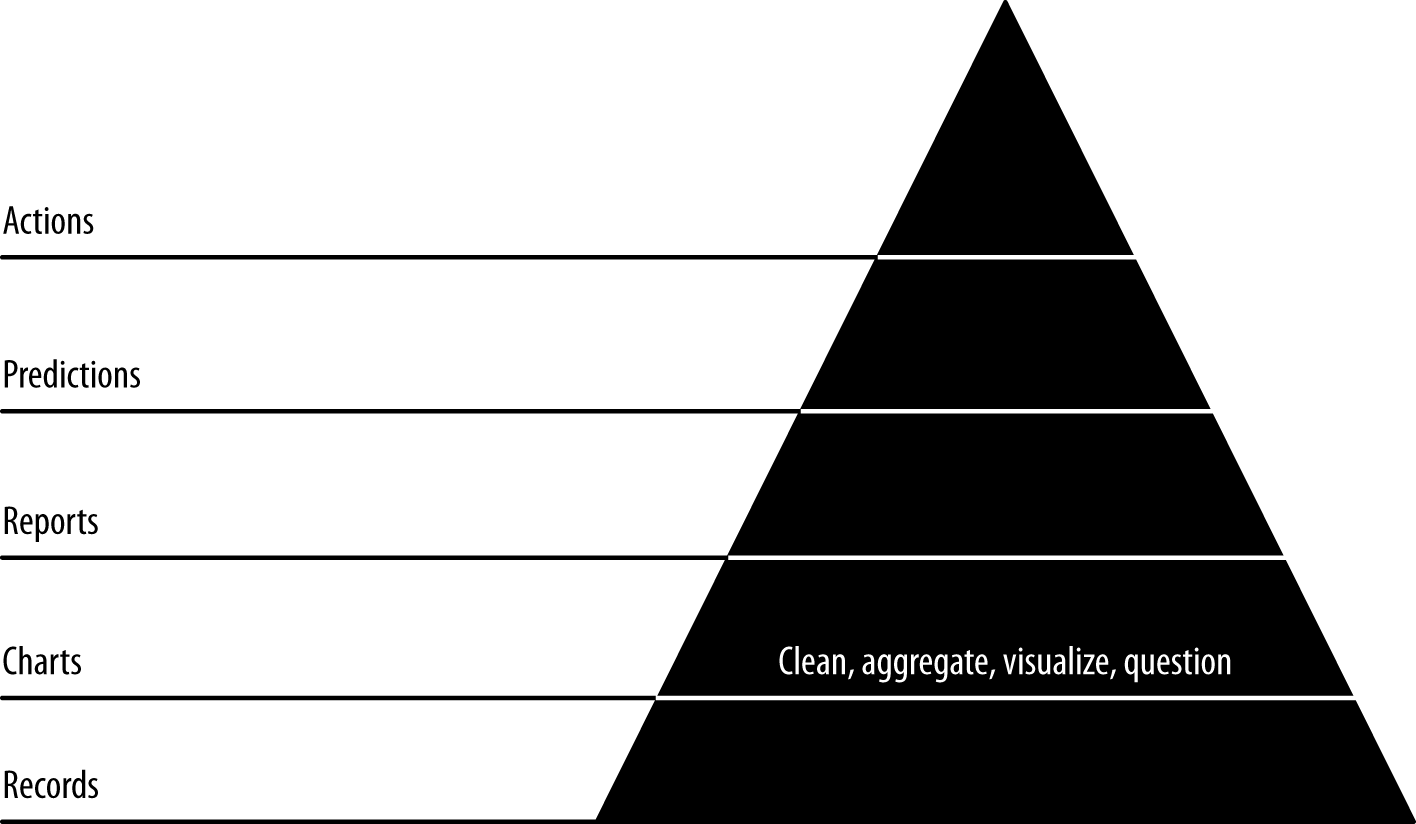

# Visualizing Data with Charts and Tables

Charts are our first view into our data in aggregate, mapping the properties of many records into visual representations that help us understand and navigate them. Our goals in this step are to publish charts to generate interest in our data and get users interacting with it, to build reusable tools that will help us explore our data interactively in reports in the next step, and to begin extracting structure and entities so that we can create new features and insights with this structure.

## Chart Quality: Iteration Is Essential

A good chart is one that tells a story, that yields insight, and that users find interesting enough to share and respond to. In practice, most charts fail to achieve this, and have little value. Rare is the chart that tells a story. This is because most people make a chart and move on… when in reality, you have to iteratively create and improve charts to achieve useful visualizations. Expect to throw many charts away before you find a few good ones—don’t try to specify them up front or you will be disappointed. Instead, try to use your intuition and curiosity to add charts organically, as you engage in ad hoc, interactive exploratory data analysis.

You can create charts in an ad hoc way at first, but as you progress, your workflow should become increasingly automated and reproducible. In Agile Data Science, we take a web-first approach to creating visualizations. While it is easier to create charts as images using matplotlib or R than it is to create web charts, this is changing fast. With modern JavaScript chart libraries, there isn’t much overhead to creating a web-based chart, so that is what we do from the beginning.

Well-formed URLs with slugs or query parameters can be made to generalize, so one chart works for different slices of data according to different parameters and options. Once we master charts, in the next chapter, we will improve and extend our successful charts into full-blown interactive reports.

## Scaling a Database in the Publish/Decorate Model

A concept related to database normalization that we must understand is how we compute, publish, and consume data for charts and other services, and where we put the data processing. The more processing you do in batch and the less processing you do at the publishing/database layer, the less you have to spend time operating a database. There are several patterns of data access that come with their own methods of data processing and database operations. We will briefly discuss them all and illustrate their operation both in batch and in serving published results in real time.

Which form is right for you depends on your application and data access patterns; your hardware budget; and the volume of your desire to depend on, operate, and tune a database. The less batch processing we do, the less efficient storage form we use, and the more features of a database we depend on, the more we have to tune and operate the database. This could be great, because we like operating databases. Or, from my perspective most of the time, it could be bad, because I’d rather not spend more than a few minutes a week operating a database.

We’re going to discuss how to store a time series chart at decreasing levels of scalability and increasing levels of sophistication of the required database. For instance, operating a key/value store like Cassandra or Voldemort is extremely easy. There is no single point of failure, so you have room to sleep and ignore your database. By contrast, when operating a Bigtable clone where you have a master, there is a single point of failure, which is more likely to happen. When your master fails, your application will be down at least momentarily. This will require administration tasks to fix. If you employ an even more featureful database like MongoDB or MySQL, you will have to administer those features you make use of by, for instance, creating indexes to enable efficient access.

Note, though, that any database can be used simply as a key/value store, no matter how many features it offers. MySQL is very featureful, but if you don’t employ its features, it makes a very simple and efficient key/value store. You simply store a JSON representation of your data and access it via a SELECT on its primary key. This may make sense for your application if you’re a MySQL expert.

The point I want to make is that the more you compute in batch and the less you use database features, the simpler your application will be to operate and the more scalable it will be. Use database features thoughtfully. Prefer batch computing to employing database features and you will have an application that operates itself, instead of one that requires your constant attention.

### First Order Form

The most scalable form of data is where you prepare the records for your chart, table, or prediction in their entirety and store those as a single, nested object within a key/value or document store (although technically, you can use any database as a key/value store by encoding the value in JSON and storing the record under its primary key). For instance, to store a time series chart’s data, we would compute a sorted list of the values for the chart and encapsulate this list in an object with a primary key, through which we would access the chart’s data in one query.

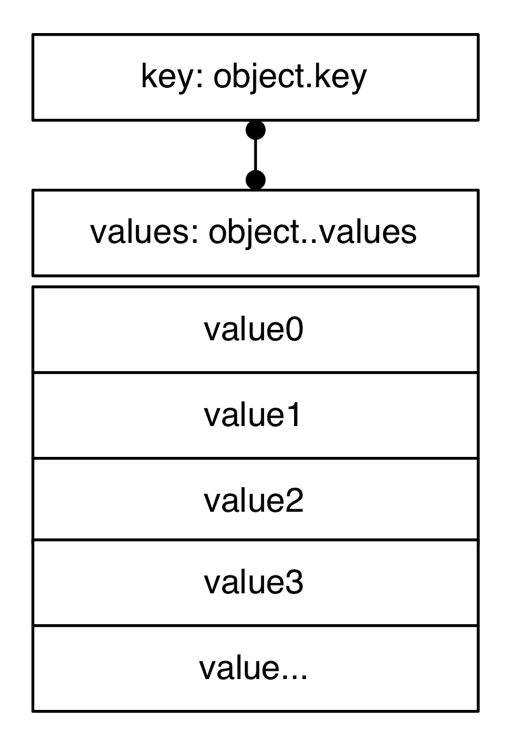

The image below shows an example of this kind of prepare/publish model. In this form, we prepare an object containing a table of flights in sorted order inside a field called Flights. The object also has a primary key field called `TailNum`, which we use to access it.

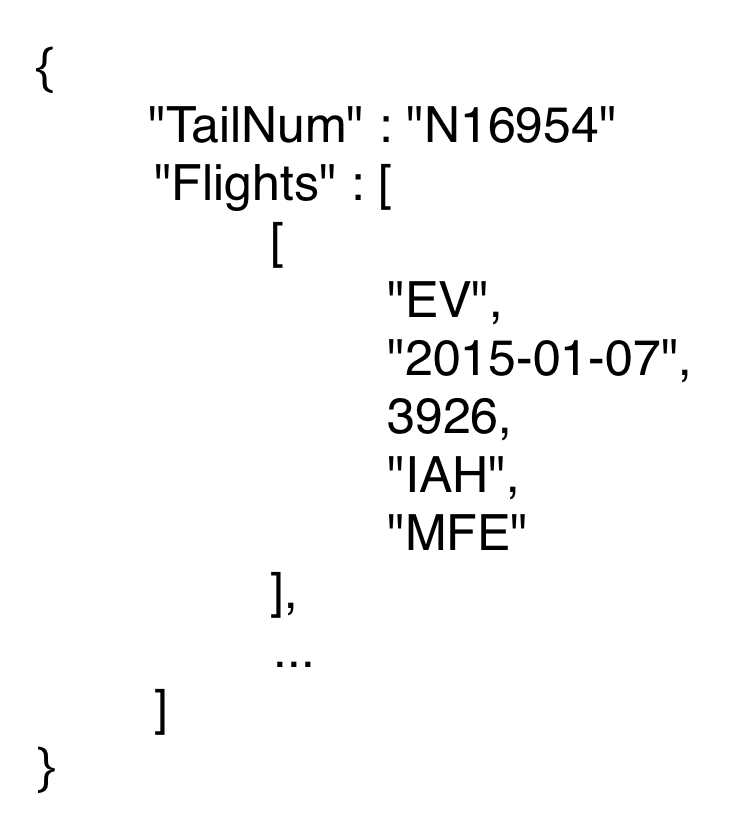

This form is the most scalable of all because you need use only a key/value store to hold the data, and to query this data you use a single, unique key. Serving data from a key/value store is a much simpler problem than most relational databases, for instance, solve. This makes them easy to operate in systems without a single point of failure. This translates into simple operations. Remember: first order form makes operations easy.

### Second Order Form

The next most scalable form takes advantage of key range scans in Google Bigtable clones like Apache HBase. Data in HBase tables is stored sorted by key, in alphabetical order. This is a critical feature because it means you can access a range of values very efficiently, the records for similar keys being near (next to) one another on disk.

Key design then becomes the mechanism through which you can perform many operations you might expect from relational databases. Apache Phoenix provides a SQL abstraction on top of HBase, which means you don’t have to employ tricks in Java to make HBase go. Phoenix is the go-to way to use HBase for application developers (who need to get things done quickly). An excellent “Introduction to HBase Schema Design” by Amandeep Khurana is available if you’d like to dive deeper.

We don’t employ HBase in the book, but the image below shows what our last example might look like in HBase land. To reproduce the query, we would compose a unique key for our data so that when stored in sorted order and retrieved by a scan against the TailNum it would produce a sorted list of flights identical to the one in the previous example.

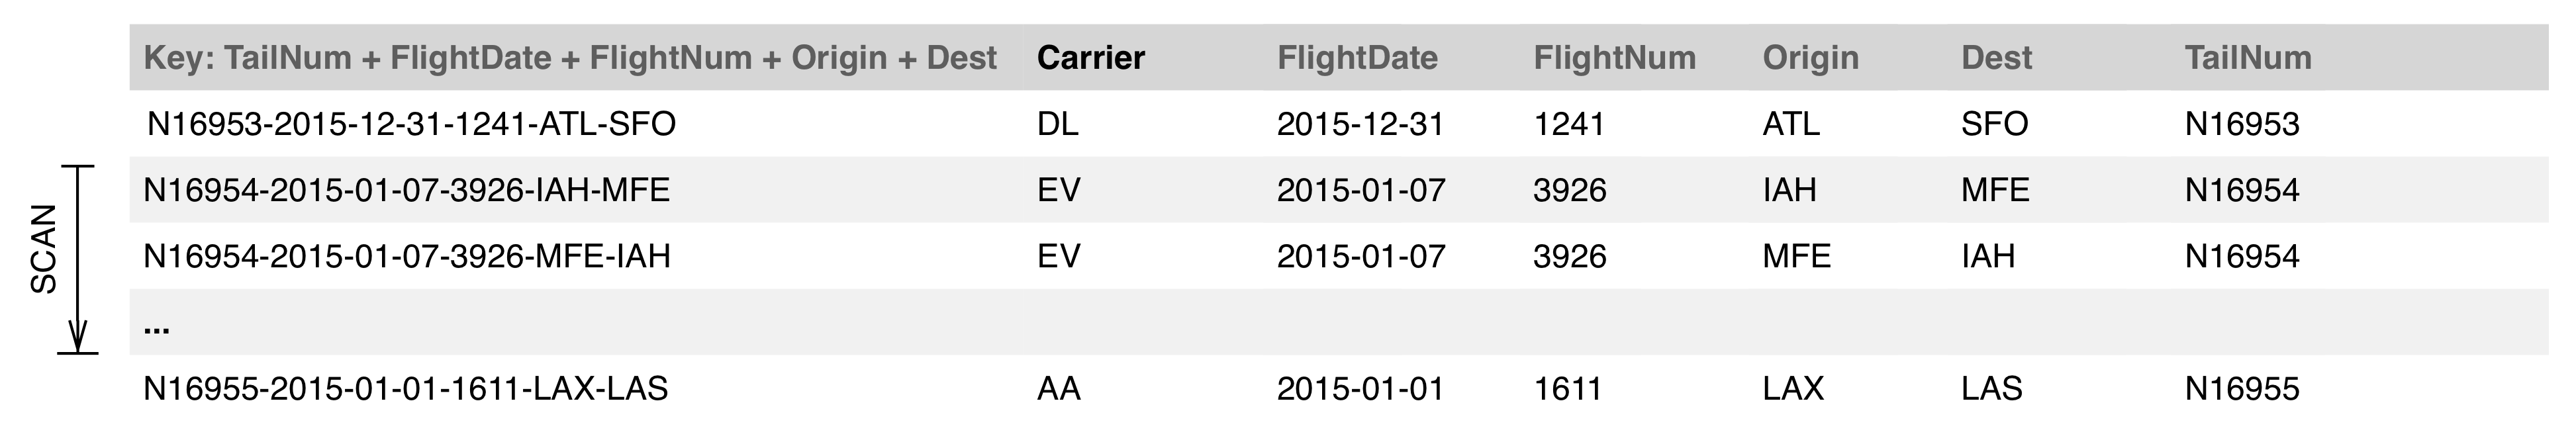

Range scans can be used to handle many types of query through novel key composition. They are surprisingly powerful, and yet they scale surprisingly well. HBase applications handling petabytes of data exist and operate with relative ease. We could easily have employed HBase and Apache Phoenix to produce many of the examples in this book. Remember: if first order form won’t work for you, second order form becomes the go-to form.

```sql
# Achieve everything many access patterns via key composition:

Requirement: SELECT FLIGHTS WHERE FlightDate < X AND FlightDate> Y

Compose Key: TailNum + FlightDate, ex. N16954-2015-12-16

Range Scan: FROM: N16954-2015-12-01 
              TO: N16954-2015-01-01
```

### Third Order Form

The next most efficient way to store data is to summarize it in terms of time or category and store the result in a database like MySQL or MongoDB that employs B-tree indexes to enable efficient lookup of portions of rows in a table, or to facilitate joins. This could replicate a range scan, or it could enable arbitrary, more complex queries that don’t resemble a range scan on a sorted table at all. These databases often include the capability to GROUP BY and compute aggregate metrics, similar to what we’ve done with Spark SQL.

Queries against relational and featureful document stores might compute any given metric at the time of query, or a hybrid approach might occur in which precomputed summaries are delivered by selecting a range of records, similar to a key range scan. We won’t demonstrate third order form in this book, but you’re probably familiar with it already. It can break the publish/decorate model we’ve used in this book, or it might simply serve range scans on preaggregated metrics.

### Choosing a Form

In general, the lower order form you choose, the easier the system is to scale, and to scale horizontally. But remember: you can always choose a more featureful database and not use its features, except in cases of dire need. For instance, you might use MySQL as a key/value store, or to serve range scans of preaggregated metrics. It will scale easily when used this way. You would have the option, however, of using a GROUP BY if you needed to, in order to more rapidly implement a new feature of your application. You could always scale the feature by moving the processing “back in the stack” to the batch layer if it proves popular.

The key lesson here is to use database features thoughtfully, because the more you use them, the more difficult your application will be to scale. Batch computation is relatively easy compared to keeping a large and featureful database instance going under heavy load. You will need to know your database well, and understand the consequences of each feature on the system overall.

## Exploring Seasonality

We have to begin somewhere, so let’s begin with a question: which is the busiest month for air travel?

This question involves seasonality. Seasonality is present when a measure changes repeatedly and consistently, depending on the time of year. For instance, Christmas light sales would display strong seasonality (although I hang them year round), with sales peaking in December every year.

This is a chance to show how SQL and NoSQL dataflows fit together and complement one another. Let’s make our first chart, in which we count the total flights by month for the year 2015. Flights by month is very easily expressible as SQL.

In [1]:
# Initialize PySpark
APP_NAME = "Introducing PySpark"

# If there is no SparkSession, create the environment
try:
  sc and spark
except NameError as e:
  import findspark
  findspark.init()
  import pyspark
  import pyspark.sql

  sc = pyspark.SparkContext()
  spark = pyspark.sql.SparkSession(sc).builder.appName(APP_NAME).getOrCreate()

print("PySpark initialized...")

PySpark initialized...


In [4]:
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')

# Use SQL to look at the total flights by month across 2015
on_time_dataframe.registerTempTable("on_time_dataframe")
total_flights_by_month = spark.sql(
  """SELECT INT(Month), INT(Year), COUNT(*) AS total_flights
  FROM on_time_dataframe
  GROUP BY INT(Year), INT(Month)
  ORDER BY INT(Year), INT(Month)"""
)

# This map/asDict trick makes the rows print a little prettier. It is optional.
flights_chart_data = total_flights_by_month.rdd.map(lambda row: row.asDict())
flights_chart_data.collect()

[{'Month': 1, 'Year': 2015, 'total_flights': 469968},
 {'Month': 2, 'Year': 2015, 'total_flights': 429191},
 {'Month': 3, 'Year': 2015, 'total_flights': 504312},
 {'Month': 4, 'Year': 2015, 'total_flights': 485151},
 {'Month': 5, 'Year': 2015, 'total_flights': 496993},
 {'Month': 6, 'Year': 2015, 'total_flights': 503897},
 {'Month': 7, 'Year': 2015, 'total_flights': 520718},
 {'Month': 8, 'Year': 2015, 'total_flights': 510536},
 {'Month': 9, 'Year': 2015, 'total_flights': 464946},
 {'Month': 10, 'Year': 2015, 'total_flights': 486165},
 {'Month': 11, 'Year': 2015, 'total_flights': 467972},
 {'Month': 12, 'Year': 2015, 'total_flights': 479230}]

### Saving Records to MongoDB

In [5]:
# Save chart to MongoDB
import pymongo_spark
pymongo_spark.activate()
flights_chart_data.saveToMongoDB('mongodb://localhost:27017/agile_data_science.flights_by_month')

print("Saved records to MongoDB!")

### Verifying Records in MongoDB

This time we'll use the `mongo` client's `--eval` option to run a query from bash.

In [7]:
%%bash

mongo agile_data_science --eval 'db.flights_by_month.find().sort({"Year": 1, "Month": 1})'

MongoDB shell version v3.6.4
connecting to: mongodb://127.0.0.1:27017/agile_data_science
MongoDB server version: 3.6.4
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb40"), "total_flights" : 469968, "Month" : 1, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb41"), "total_flights" : 429191, "Month" : 2, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb42"), "total_flights" : 504312, "Month" : 3, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb45"), "total_flights" : 485151, "Month" : 4, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb4d"), "total_flights" : 496993, "Month" : 5, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb4f"), "total_flights" : 503897, "Month" : 6, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb4a"), "total_flights" : 520718, "Month" : 7, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb51"), "total_flights" : 510536, "Month" : 8, "Year" : 2015 }
{ "_id" : ObjectId("5ae8b0e22a35e712fda1bb57"), "total_fl

### Serving Results in Flask

Let's quickly create two controllers, one to serve an HTML page. Check out [ch05/web/chart_flask.py](web/chart_flask.py):

```python
# Controller: Fetch a flight table
@app.route("/total_flights")
def total_flights():
  total_flights = client.agile_data_science.flights_by_month.find({}, 
    sort = [
      ('Year', 1),
      ('Month', 1)
    ])
  return render_template('total_flights.html', total_flights=total_flights)
```

Before we make a chart, we’re going to create a simple table, as we did in the last chapter. Check out [ch05/web/templates/total_flights.html](web/templates/total_flights.html):

```html
{% extends "layout.html" %}
{% block body %}
  <div>
    <p class="lead">Total Flights by Month</p>
    <table class="table table-condensed table-striped" style="width: 200px;">
      <thead>
        <th>Month</th>
        <th>Total Flights</th>
      </thead>
      <tbody>
        {% for month in total_flights %}
        <tr>
          <td>{{month.Month}}</td>
          <td>{{month.total_flights}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
  </div>
{% endblock %}
```

### Total Flights Data Table

Check out the result by changing directory to `ch05/web` and running `chart_flask.py`.

```bash
cd ch05/web
python ./chart_flask.py
```

Now visit the results at [http://localhost:5000/total_flights](http://localhost:5000/total_flights)

You should see this:

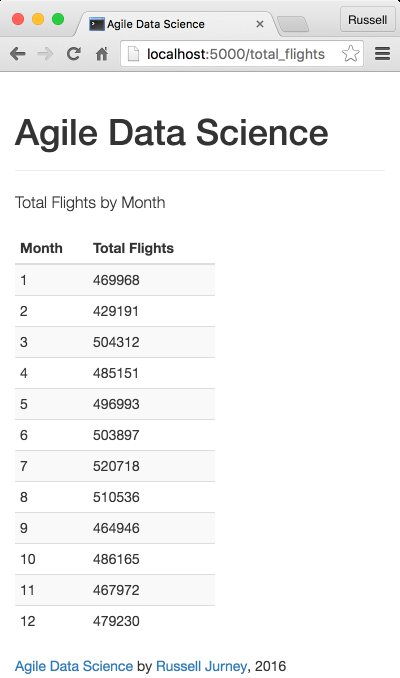

### Total Flights Chart

#### Controllers

As far as presenting data in tables, that is it! This is the place to start, but I can’t look at that table and notice any trends—can you? Let’s use d3.js to make a time series chart. We’ll start by making a controller in Flask to serve our chart page, and a derivative of our table controller that serves the JSON data for our chart. Check out [ch05/web/chart_flask.py](web/chart_flask.py):

```python
# Serve the chart's data via an asynchronous request (formerly known as 'AJAX')
@app.route("/total_flights.json")
def total_flights_json():
  total_flights = client.agile_data_science.flights_by_month.find({}, 
    sort = [
      ('Year', 1),
      ('Month', 1)
    ])
  return json_util.dumps(total_flights, ensure_ascii=False)

# Controller: Fetch a flight chart
@app.route("/total_flights_chart")
def total_flights_chart():
  total_flights = client.agile_data_science.flights_by_month.find({}, 
    sort = [
      ('Year', 1),
      ('Month', 1)
    ])
  return render_template('total_flights_chart.html', total_flights=total_flights)
```

#### Template 

The template for our chart is relatively simple: it starts as a paste from an [example](https://bost.ocks.org/mike/bar/3/) by d3.js creator __Mike Bostock__. In the last edition we started with an example by Mike, and then showed how you might have built it from the ground up—but we did not build it from the ground up (we did credit Mike’s example). You never build them from the ground up, so in this edition I’m going to tell the truth about D3: nearly all D3 charts begin as examples from Mike Bostock. Taking examples and adapting them to your needs is a skill fundamental not just to visualization, but to all data science and programming in general. Nobody knows everything, and the job involves a lot of figuring things out. This edition aims to teach you to do that.

Our template reproduces the CSS style code from the example. Check out [ch05/web/total_flights_chart.html](web/total_flights_chart.html):

```html
{% extends "layout.html" %}
{% block body %}
<style>

.chart rect {
  fill: steelblue;
}

.chart text {
  fill: white;
  font: 10px sans-serif;
  text-anchor: middle;
}

</style>
  
  <div>
    <p class="lead">Total Flights by Month</p>
    <div id="chart"><svg class="chart"></svg></div>
  </div>
  <script src="/static/app.js"></script>
{% endblock %}
```

#### `d3.js` Javascript

It also puts the JavaScript from the same example into [ch05/web/static/app.js](web/static/app.js), with a few changes. d3.tsv won’t work for us, unless we copy the example’s data over. We need to edit just a few things to get the example working. 

```javascript
// Define the width and height of our chart
var width = 960,
    height = 350;

// Define the y scale, which is linear and maps to between the range of the height of the chart and 0
var y = d3.scale.linear()
    .range([height, 0]);
    // We define the domain once we get our data in d3.json, below

// Our chart object is defined using the height and width
var chart = d3.select(".chart")
    .attr("width", width)
    .attr("height", height);

// We fetch the JSON from our controller, then process the resulting data
d3.json("/total_flights.json", function(data) {

    // We define colors for the bars. Most examples use steel blue for some reason?
    var barColor = 'steelblue';
    
    // We compute the maximum value for the bars, then set the domain for the y axis.
    // This means that y will now map from [0 -> maxY] to [height -> 0].
    var maxY = d3.max(data, function(d) { return d.total_flights; });
    y.domain([0, maxY]);
    
    // Divide the width by the number of bars to get the bar width
    var barWidth = width / data.length;
    
    // We create our bar set of SVG containers (g elements) with attached data (the total_flights)
    // where each one is offset (transalted) by the barWidth of its index in the list of data values.
    var bar = chart.selectAll("g")
        .data(data)
        .enter()
        .append("g")
        .attr("transform", function(d, i) { return "translate(" + i * barWidth + ",0)"; });
    
    // Now we define a rectangle for each container with the height mapped from the total_flights data point
    // to the y axis, and the width barWidth - 1 pixel. We will it with the bar color.
    bar.append("rect")
        .attr("y", function(d) { return y(d.total_flights); })
        .attr("height", function(d) { return height - y(d.total_flights); })
        .attr("width", barWidth - 1)
        .style("fill", barColor);

    // We then label each bar with a the raw value in the top middle of the bar.
    // We offset the label by 3 to make it under the end of the bar, in the blue bit and we make it white
    // to stand out from the blue using the CSS from the HTML template above for text.
    bar.append("text")
        .attr("x", barWidth / 2)
        .attr("y", function(d) { return y(d.total_flights) + 3; })
        .attr("dy", ".75em")
        .text(function(d) { return d.total_flights; });
});
```

#### End Result 1.0

This produces a chart detailing how flight volume changes per month. Check out [http://localhost:5000/total_flights_chart](http://localhost:5000/total_flights_chart):

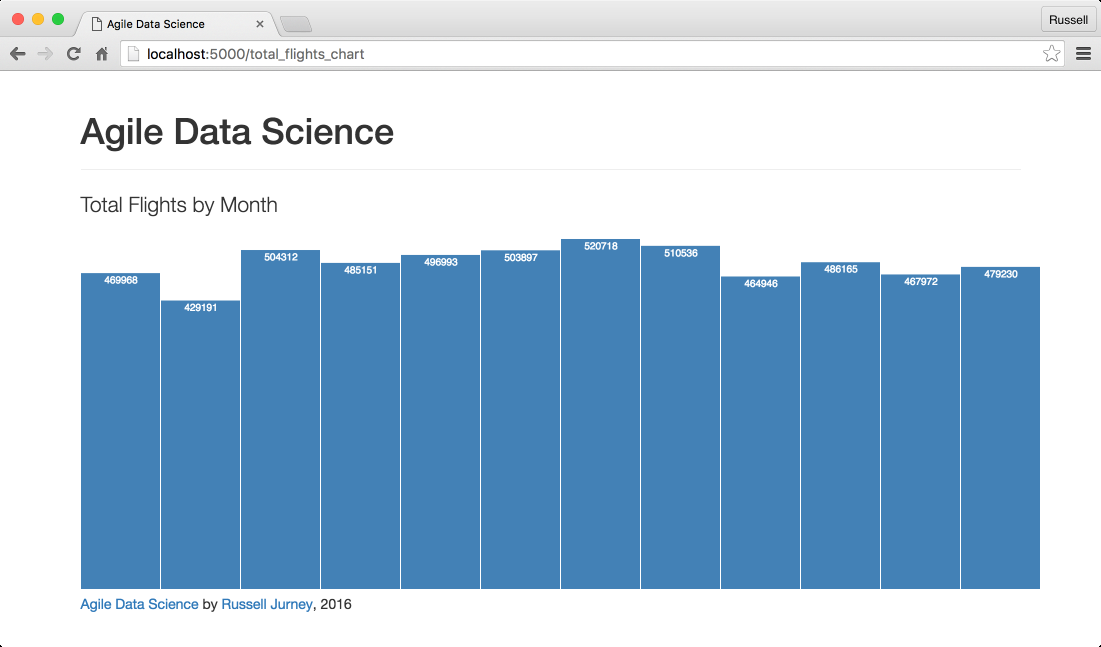

#### Conclusion

We’ve created a simple chart in d3.js. Note that we haven’t gotten fancy, and when you first create a chart you shouldn’t. Start with something that simply visualizes the data, and then add bells and whistles once you’ve found a chart that merits it.

## Iterating on Our First Chart

True to our introduction, we’re going to iterate on this chart to help answer our original question, “Which is the busiest month for air travel?” Can you tell by looking at this chart what the answer to that question is? Looking very carefully, I see it’s July, but I can’t easily tell at a glance.

### Highlighting our Question's Answer

The question our query and chart are really asking is, for a given year of total flights by month, what month is the mode? Wikipedia defines mode as “the value that appears most often in a set of data.” We can improve our chart by highlighting the mode, since it isn’t obvious from the bars alone. Let’s edit [ch05/web/app.js](web/app.js) as [ch05/web/app2.js](web/app2.js) to highlight the mode, so it is apparent at a glance. We'll also need a new controller to serve a page pointing at `app2.js`. Note that we can re-use the controller serving `/total_flights.json`, which is nice!

The controller is just a copy of the first one with a `_2` appended to the route, function name and template name.

### Controller 2.0

```python
# Controller: Fetch a flight chart 2.0
@app.route("/total_flights_chart_2")
def total_flights_chart_2():
  total_flights = client.agile_data_science.flights_by_month.find({}, 
    sort = [
      ('Year', 1),
      ('Month', 1)
    ])
  return render_template('total_flights_chart_2.html', total_flights=total_flights)
```

### Template 2.0

The template simply points at `app2.js` instead of `app.js`:

```html
{% extends "layout.html" %}
{% block body %}
<style>

.chart rect {
  fill: steelblue;
}

.chart text {
  fill: white;
  font: 10px sans-serif;
  text-anchor: middle;
}

</style>
  
  <div>
    <p class="lead">Total Flights by Month</p>
    <div id="chart"><svg class="chart"></svg></div>
  </div>
  <script src="/static/app2.js"></script>
{% endblock %}
```

### `app2.js`

Finally, we need to copy `app.js` over as `app2.js` and edit it to highlight the mode. First we need to create a function called `varColor`, which will return a different color when the value is the maximum. We apply this to the chart’s bar/rectangle selection using D3’s style method:

```javascript
// We fetch the JSON from our controller, then process the resulting data
d3.json("/total_flights.json", function(data) {

    // We define colors for the bars - one for default, one for the mode
    var defaultColor = 'steelblue';
    var modeColor = '#4CA9F5';
    
    ...
    
    // Color the bar with the maximum value, the mode, differently
    var varColor = function(d, i) {
        if(d['total_flights'] == maxY) { return modeColor; }
        else { return defaultColor; }
    }
    
    ...
    
    // Plug in varColor to color the mode's bar differently
    bar.append("rect")
        .attr("y", function(d) { return y(d.total_flights); })
        .attr("height", function(d) { return height - y(d.total_flights); })
        .attr("width", barWidth - 1)
        .style("fill", varColor);
```

### End Result 2.0

The result makes the answer to our question readily apparent. Check it out at [http://localhost:5000/total_flights_chart_2](http://localhost:5000/total_flights_chart_2)

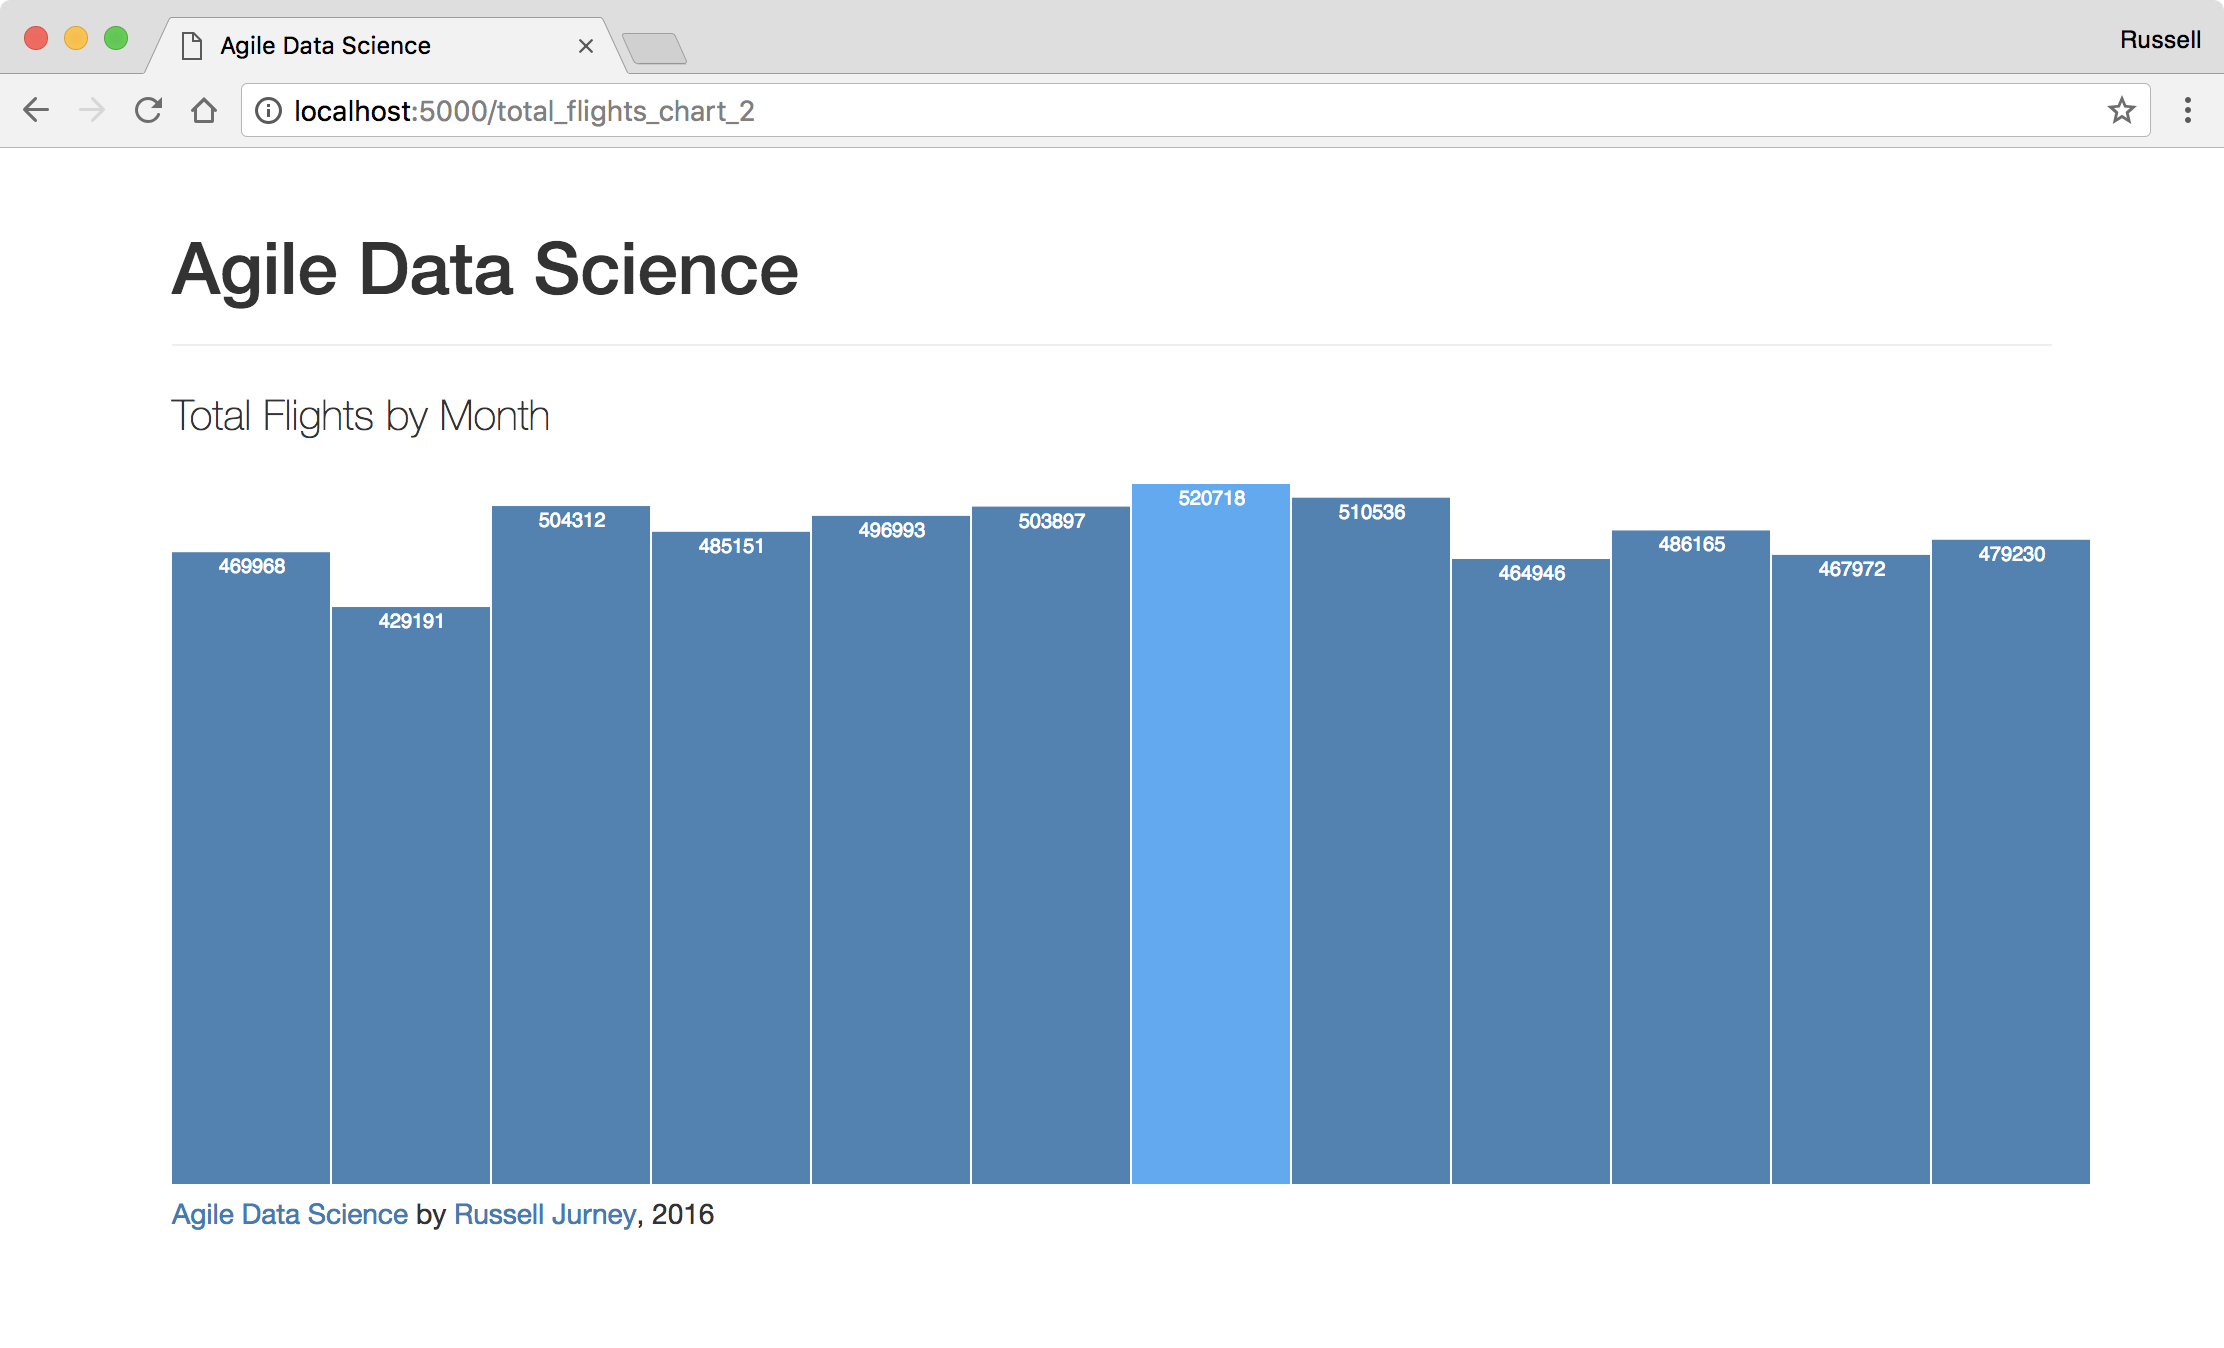

### Conclusion

This completes the titular element of the second level of the data-value pyramid. Now let’s explore another element: entity extraction.

## Extracting Metal (Airplanes [Entities])

There is another element to the charts layer of the data-value pyramid: __entity extraction__. Entity extraction is implicit during chart creation, in the sense that we are grouping atomic records on properties to produce aggregates. Entities often emerge as a next step in our analysis. For instance, having listed and searched flights in the previous chapter and having aggregated flights in this one, it is natural to dig into some other aspects of the flights themselves: __airplanes__, __airlines__, and __airports__. 

The image below of the flight search interface example from [chapter 4](../ch04/Collecting and Displaying Records.ipynb) shows the entities we might want to extract.

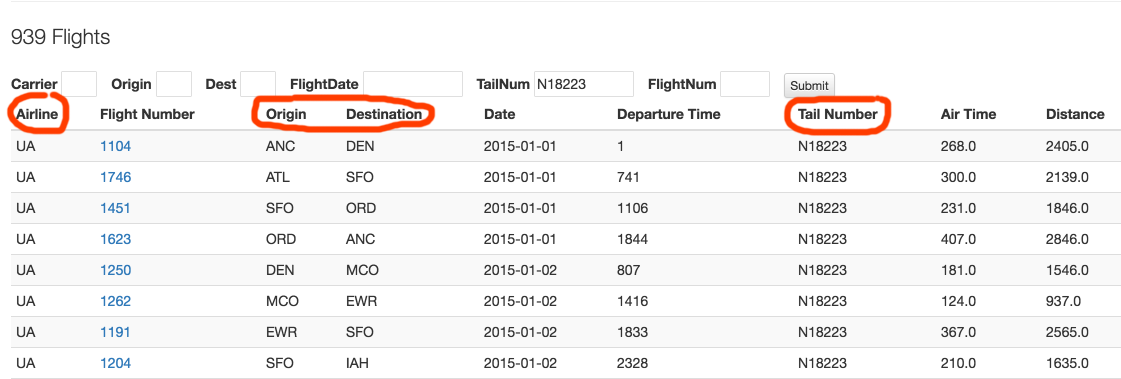

Let’s focus on one entity to start: __airplanes__. An airplane is referred to as the “__metal__” of a flight, and a _tail number_ is a unique identifier for an airplane. We’re going to extract airplanes by their tail number, in order to demonstrate how to extract entities from raw data. We will create a new entity for each tail number, and it will list all flights for that plane.

### Extracting Tail Numbers

We start by creating an index of all flights for a given airplane, represented by its TailNum field. We’ll create a tuple with a tail number as the first field, and every unique flight that tail number made in 2015 as the second field, sorted by date.

#### Data Processing: Batch of Realtime?

We are now presented with a choice: where to implement this feature. This decision is a common one you will experience in the field working on real data applications. The general rule is to prototype anywhere, at any layer from Spark to HTML mocks, but to push to batch processing as you are able.

The first option in this case is using PySpark to group flights by tail number. This method puts all of our processing at the far backend in batch, which would be desirable for very large data. The second method is to use a MongoDB query or Elasticsearch facets to query our flight record index just as we have before, but with different handling in our web application.

In this instance, we choose to group flights in PySpark and store them in MongoDB. We do this because we intend to use this data in other analyses via joins, and while we can read data from Elasticsearch in PySpark, it is important to have a copy of intermediate data on reliable bulk storage, where it is truly persistent and easily accessible. We know we can easily and arbitrarily scale operations in Spark, so doing data processing in this layer is conservative.

#### Grouping and Sorting Data in Spark

We’ll need to group by tail number to get a list of flights per airplane, identified by carrier, date, origin/destination, and flight number. Note that for round-trip flights, where a plane turns around and goes directly back to where it came from, there are often two flights per day with the same carrier and flight number; one for coming and one for going.

Check out [ch05/extract_airplanes.py](extract_airplanes.py). 

##### Trimming Our Records

First we load the data, and then we filter down to the fields we need. Dropping unneeded, extra fields is always a good idea to keep things performant:

In [10]:
# Load the parquet file
on_time_dataframe = spark.read.parquet('../data/on_time_performance.parquet')
on_time_dataframe.registerTempTable("on_time_performance")

# Filter down to the fields we need to identify and link to a flight
flights = on_time_dataframe.rdd.map(
    lambda x: 
  {
      'Carrier': x.Carrier, 
      'FlightDate': x.FlightDate, 
      'FlightNum': x.FlightNum, 
      'Origin': x.Origin, 
      'Dest': x.Dest, 
      'TailNum': x.TailNum
  }
)
flights.first()

{'Carrier': 'AA',
 'FlightDate': '2015-01-01',
 'FlightNum': '1519',
 'Origin': 'DFW',
 'Dest': 'MEM',
 'TailNum': 'N001AA'}

##### Combining Lists in MapReduce 

Now, we group flights by tail number and then sort these flights by date, flight number, then origin/destination airport codes. Note that the first step in achieving this is to create a tuple where the first field is the tail number, and the second field is a one-tuple list. What good is a one-tuple list? 

Lists in Python can be added like so:

```python
a = [0]
b = [1]
c = a + b
print(c)
```

The result is:

```python
[0, 1]
```

Here we will add lists in our reduce step, so we need to initialize them in our map step. The Map in MapReduce prepares your data for aggregation in the group step.

##### The Map in MapReduce

```python
flights.map(lambda record: (record['TailNum'], [record]))
```

##### Aggregation by Reduce

Next, we aggregate a list per key by adding them in a reduce step:

```python
.reduceByKey(lambda a, b: a + b)\
```

##### Computation Among Groups in Reduce

Finally, we produce a dict we can store in Mongo. We also sort the list of flights we just aggregated by date, flight number, then origin and destination:

```python
.map(lambda tuple:
  {
    'TailNum': tuple[0], 
    'Flights': sorted(tuple[1], key=lambda x: (x['FlightNum'], x['FlightDate'], x['Origin'], x['Dest']))
  }
)
```

#### All Together

Here we combine the above lines of code into one piece and execute it. Note that we use the `pyspark.RDD.first()` method to see the first record produced by the map/reduce operation.

In [11]:
# Group flights by tail number, sorted by flight number, date, then origin/dest
flights_per_airplane = flights\
  .map(lambda record: (record['TailNum'], [record]))\
  .reduceByKey(lambda a, b: a + b)\
  .map(lambda tuple:
      {
        'TailNum': tuple[0], 
        'Flights': sorted(tuple[1], key=lambda x: (x['FlightNum'], x['FlightDate'], x['Origin'], x['Dest']))
      }
    )
flights_per_airplane.first()

{'TailNum': 'N11165',
 'Flights': [{'Carrier': 'EV',
   'FlightDate': '2015-06-04',
   'FlightNum': '3256',
   'Origin': 'ORD',
   'Dest': 'CAK',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-07-12',
   'FlightNum': '3256',
   'Origin': 'OMA',
   'Dest': 'ORD',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-08-01',
   'FlightNum': '3256',
   'Origin': 'ORD',
   'Dest': 'CAK',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-12-11',
   'FlightNum': '3256',
   'Origin': 'ORD',
   'Dest': 'CID',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-12-28',
   'FlightNum': '3256',
   'Origin': 'ROC',
   'Dest': 'ORD',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-06-23',
   'FlightNum': '3257',
   'Origin': 'ORD',
   'Dest': 'RIC',
   'TailNum': 'N11165'},
  {'Carrier': 'EV',
   'FlightDate': '2015-08-03',
   'FlightNum': '3257',
   'Origin': 'GSP',
   'Dest': 'ORD',
   'TailNum': 'N11165'},
 

#### Saving to MongoDB

Finally, we save the entire dataset to MongoDB in the `agile_data_science` database in the `flights_per_airplane` collection, where it can be accessd by `TailNumber`.

In [12]:
# Save to Mongo
import pymongo_spark
pymongo_spark.activate()

flights_per_airplane.saveToMongoDB('mongodb://localhost:27017/agile_data_science.flights_per_airplane')

print("Collection saved to MongoDB!")

Collection saved to MongoDB...


#### Verifying Our Record in MongoDB

Lets check our records in MongoDB:

In [14]:
%%bash

mongo agile_data_science --eval 'db.flights_per_airplane.findOne()'

MongoDB shell version v3.6.4
connecting to: mongodb://127.0.0.1:27017/agile_data_science
MongoDB server version: 3.6.4
{
	"_id" : ObjectId("5ae8e5c12a35e712fda1bba8"),
	"Flights" : [
		{
			"Origin" : "DEN",
			"FlightNum" : "1030",
			"Dest" : "MSP",
			"FlightDate" : "2015-10-26",
			"Carrier" : "UA",
			"TailNum" : "N464UA"
		},
		{
			"Origin" : "DEN",
			"FlightNum" : "1030",
			"Dest" : "MSP",
			"FlightDate" : "2015-11-04",
			"Carrier" : "UA",
			"TailNum" : "N464UA"
		},
		{
			"Origin" : "IAH",
			"FlightNum" : "1055",
			"Dest" : "PHL",
			"FlightDate" : "2015-12-21",
			"Carrier" : "UA",
			"TailNum" : "N464UA"
		},
		{
			"Origin" : "CLE",
			"FlightNum" : "1072",
			"Dest" : "EWR",
			"FlightDate" : "2015-11-16",
			"Carrier" : "UA",
			"TailNum" : "N464UA"
		},
		{
			"Origin" : "ORD",
			"FlightNum" : "1072",
			"Dest" : "CLE",
			"FlightDate" : "2015-11-16",
			"Carrier" : "UA",
			"TailNum" : "N464UA"
		},
		{
			"Origin" : "IAH",
			"FlightNum" : "1077",
			"Dest" : 

### Serving Airplanes with Flask

We can see how to query airplanes by `TailNumber`, which is an important access pattern given that the tail number is a unique identifier for an airplane. This kind of data is foundational - it lets us add features to a page by directly rendering precomputed data. 

#### Controller

We’ll start by displaying these flights as list via the `/airplane/flights` controller in [ch05/web/chart_flask.py](web/chart_flask.py):

```python
# Controller: Fetch an airplane and display its flights
@app.route("/airplane/flights/<tail_number>")
def flights_per_airplane(tail_number):
  flights = client.agile_data_science.flights_per_airplane.find_one({'TailNum': tail_number})
  return render_template('flights_per_airplane.html', flights=flights, tail_number=tail_number)
```

#### Template

Our template is simple. It extends our application layout and relies on Bootstrap for styling the table. Once again, we link to the individual flight record page from the flight number in our table, composing a link using the fields of our records.

```html
{% extends "layout.html" %}
{% block body %}
  <div>
    <p class="lead">Flights by Tail Number {{tail_number}}</p>
    <table class="table table-condensed table-striped">
      <thead>
        <th>Carrier</th>
        <th>Date</th>
        <th>Flight Number</th>
        <th>Origin</th>
        <th>Destination</th>
      </thead>
      <tbody>
        {% for flight in flights['Flights'] %}
        <tr>
          <td>{{flight['Carrier']}}</td>
          <td>{{flight['FlightDate']}}</td>
          <td><a href="/on_time_performance?Carrier={{flight['Carrier']}}&FlightDate={{flight['FlightDate']}}&FlightNum={{flight['FlightNum']}}">{{flight['FlightNum']}}</a></td>
          <td>{{flight['Origin']}}</td>
          <td>{{flight['Dest']}}</td>
        </tr>
        {% endfor %}
      </tbody>
    </table>
  </div>
{% endblock %}
```

#### Result

Check out [http://localhost:5000/airplane/flights/N35236](http://localhost:5000/airplane/flights/N35236):

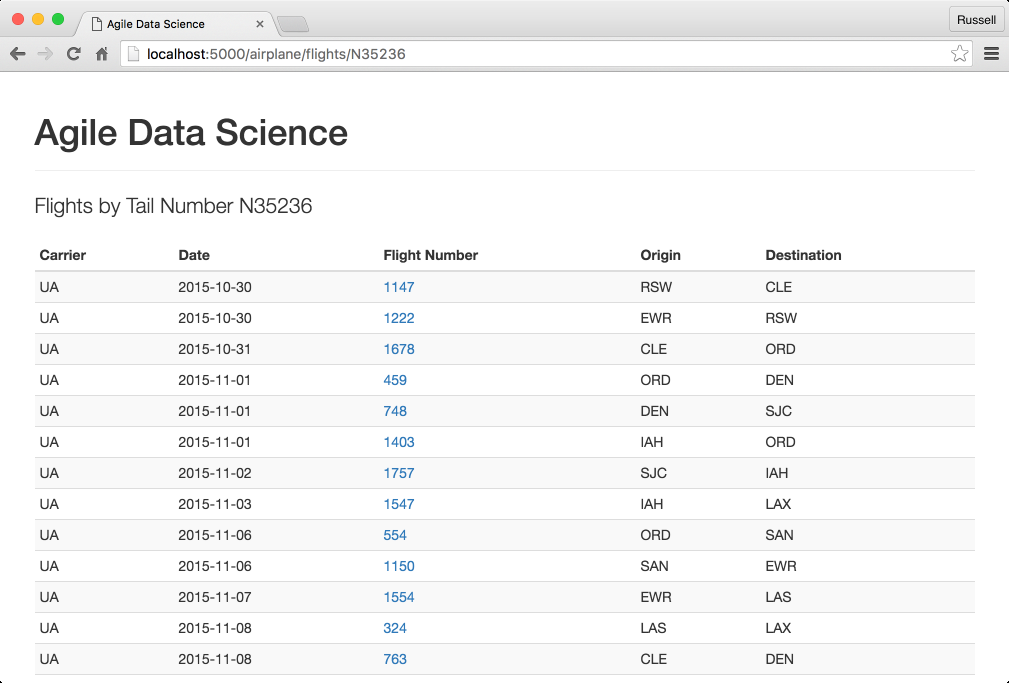

Again, note that clicking on the flight number takes you to the flight page for that flight, which we created earlier.